# MPI calibration of a Grid5000 cluster

## Data exploration

In [1]:
import os
import zipfile
import yaml
import pandas
import io
import warnings
warnings.filterwarnings("ignore")

archive_name = 'rennes_2019-08-01_1175826.zip'

def extract_zip(zip_name):
    '''Taken from https://stackoverflow.com/a/10909016/4110059'''
    input_zip = zipfile.ZipFile(zip_name)
    result = {}
    deployment = yaml.load(input_zip.read('info.yaml'))['deployment']
    experiment = zip_name
    if '/' in experiment:
        experiment = experiment[experiment.index('/')+1:]
    experiment = experiment[:experiment.index('_')]
    for name in input_zip.namelist():
        if name.endswith('.csv'):
            dataframe = pandas.read_csv(io.BytesIO(input_zip.read(name)), names = ['op', 'msg_size', 'start', 'duration'])
            dataframe['experiment'] = experiment
            dataframe['type'] = name
            dataframe['deployment'] = deployment
            dataframe['index'] = range(len(dataframe))
            result[name] = dataframe
        elif name.endswith('.yaml'):
            result[name] = yaml.load(input_zip.read(name))
        else:
            result[name] = input_zip.read(name)
    return result

def aggregate_dataframe(dataframe):
    df = dataframe.groupby('msg_size').mean().reset_index()
    for col in dataframe.columns:
        if col not in df.columns:
            value = list(dataframe[col].unique())
            if len(value) == 1:
                df[col] = value[0]
    return df

threshold = 65480  # "semantic" breakpoint, found with another script

# I really hate that we have to define these two values:
expected_bandwidth = 1e10/8
expected_latency   = 1e-5

result = extract_zip(archive_name)

In [2]:
!unzip -p $archive_name info.yaml

cluster: paravance
command: /home/tocornebize/.local/bin/peanut MPICalibration run tocornebize --jobid
  rennes:1175826 --deploy debian9-x64-base --expfile exp.csv
deployment: debian9-x64-base
expfile:
- exp.csv
git_repositories:
- hash: 7061199bdfd699841f4ee8e73f172fae47a444ea
  path: platform-calibration
  url: https://github.com/Ezibenroc/platform-calibration.git
jobid: 1175826
paravance-62.rennes.grid5000.fr:
  arp:
    dns.rennes.grid5000.fr:
    - (172.16.111.118) at 00:16:3e:5d:d9:d8 [ether] on eno1
    frennes.rennes.grid5000.fr:
    - (172.16.111.106) at 00:16:3e:bd:90:6f [ether] on eno1
    gw.rennes.grid5000.fr:
    - (172.16.111.254) at 8c:60:4f:47:6d:01 [ether] on eno1
    kadeploy.rennes.grid5000.fr:
    - (172.16.111.111) at 00:16:3e:1c:2f:56 [ether] on eno1
    parasilo-srv-1.rennes.grid5000.fr:
    - (172.16.111.22) at ec:f4:bb:d0:f9:04 [ether] on eno1
    paravance-64.rennes.grid5000.fr:
    - (172.16.96.64) at ec:f4:bb:d1:02:28 [ether] on eno1
  cpu: Intel(R) Xeon(R)

In [3]:
import pytree
print(pytree.__version__)
print(pytree.__git_version__)

0.0.6
daeffcbfbfb10dc9d69044bb110f965ab4e4e042


In [4]:
# Special processing for the Pingpong dataset
df_pingpong = result['exp/exp_PingPong.csv']
pingpong_send = df_pingpong[df_pingpong.op=='MPI_Send'].reset_index(drop=True)
pingpong_recv = df_pingpong[df_pingpong.op=='MPI_Recv'].reset_index(drop=True)
df_pingpong = pandas.DataFrame(dict(op = 'PingPong',
                   msg_size = pingpong_send.msg_size,
                   start    = pingpong_send.start,
                   duration = pingpong_recv.duration + pingpong_send.duration
              ))

df_send = pingpong_send
df_isend = result['exp/exp_Isend.csv']
df_recv = result['exp/exp_Recv.csv']
df_wtime = result['exp/exp_Wtime.csv']
df_test = result['exp/exp_Test.csv']
df_iprobe = result['exp/exp_Iprobe.csv']

### MPI_Send

In [5]:
import pytree
import matplotlib.pyplot as plt

tmp = aggregate_dataframe(df_send)
reg_send = pytree.compute_regression(x=tmp.msg_size, y=tmp.duration).auto_simplify()
print(reg_send.breakpoints)
reg_send

[65465, 250309, 373416, 385716]


-inf < x ≤ 6.546e+04
	y ~ 7.066e-11x + 2.879e-06
6.546e+04 < x ≤ 2.503e+05
	y ~ 2.399e-10x + 7.291e-05
2.503e+05 < x ≤ 3.734e+05
	y ~ 1.765e-10x + 2.325e-04
3.734e+05 < x ≤ 3.857e+05
	y ~ 2.482e-08x + -9.217e-03
3.857e+05 < x ≤ inf
	y ~ 1.074e-09x + 7.765e-06

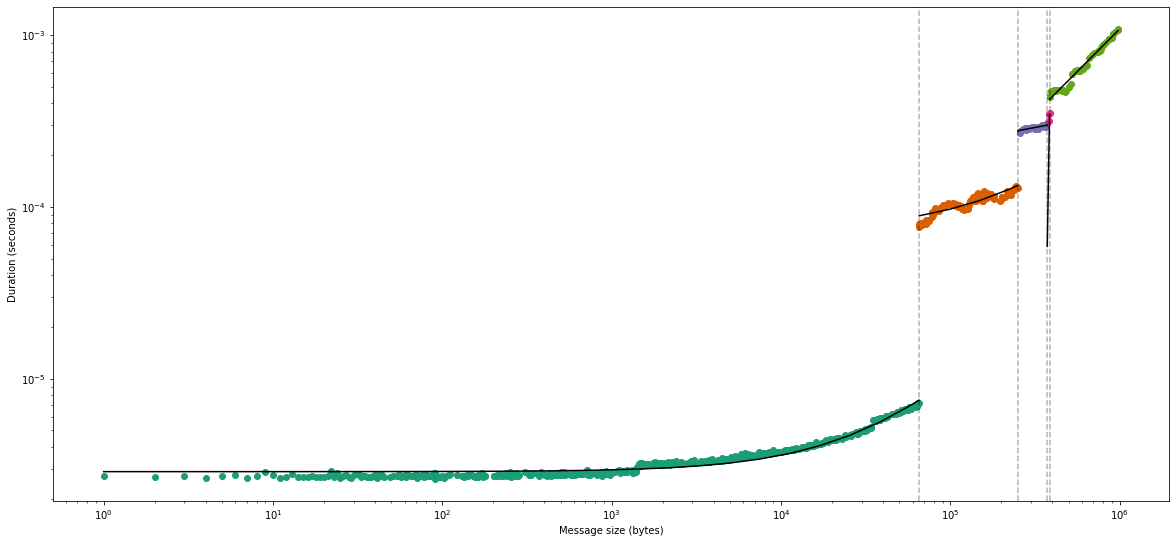

In [6]:
def draw_plot(reg, alpha=1):
    reg.plot_dataset(log=True, alpha=alpha)
    plt.xlabel('Message size (bytes)')
    plt.ylabel('Duration (seconds)')

draw_plot(reg_send)

In [7]:
breakpoints_send = set(reg_send.breakpoints)
breakpoints_send.difference_update([373416])
breakpoints_send

{65465, 250309, 385716}

### MPI_Isend

In [8]:
tmp = aggregate_dataframe(df_isend)
reg_isend = pytree.compute_regression(x=tmp.msg_size, y=tmp.duration).auto_simplify()
print(reg_isend.breakpoints)
reg_isend

[1392, 65465]


-inf < x ≤ 1.392e+03
	y ~ 1.156e-10x + 3.009e-06
1.392e+03 < x ≤ 6.546e+04
	y ~ 6.160e-11x + 3.314e-06
6.546e+04 < x ≤ inf
	y ~ 1.602e-13x + 3.267e-06

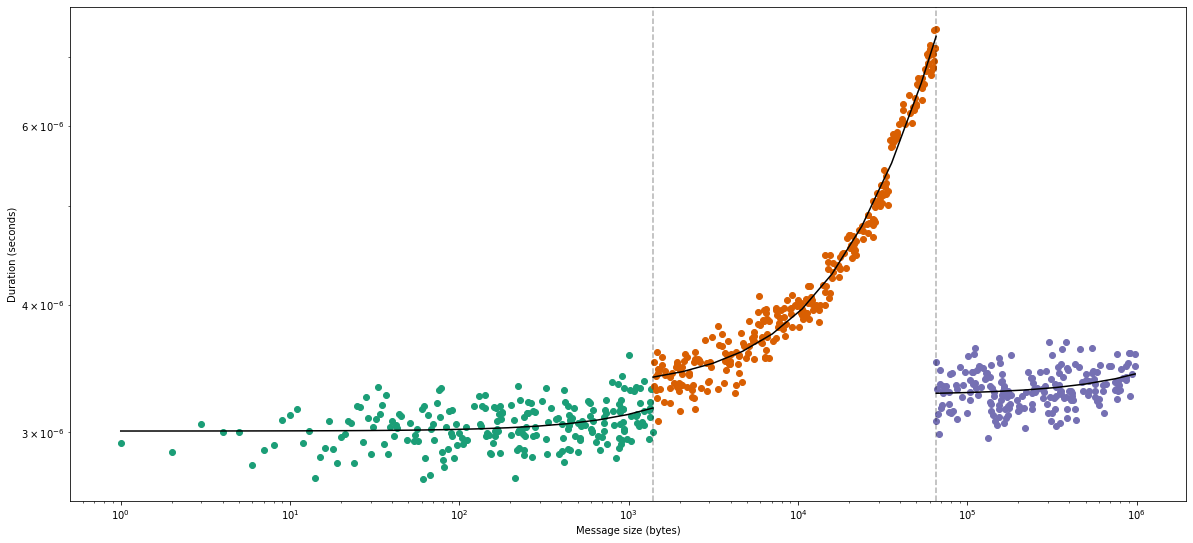

In [9]:
draw_plot(reg_isend)

In [10]:
breakpoints_isend = set(reg_isend.breakpoints)
breakpoints_isend

{1392, 65465}

### MPI_Recv

In [11]:
tmp = aggregate_dataframe(df_recv)
reg_recv = pytree.compute_regression(x=tmp.msg_size, y=tmp.duration).auto_simplify()
print(reg_recv.breakpoints)
reg_recv

[1416, 65465, 129554, 259512]


-inf < x ≤ 1.416e+03
	y ~ 1.295e-09x + 4.324e-06
1.416e+03 < x ≤ 6.546e+04
	y ~ 3.387e-10x + 8.125e-06
6.546e+04 < x ≤ 1.296e+05
	y ~ 1.073e-09x + 6.079e-05
1.296e+05 < x ≤ 2.595e+05
	y ~ 9.530e-10x + 1.417e-04
2.595e+05 < x ≤ inf
	y ~ 1.125e-09x + 1.213e-04

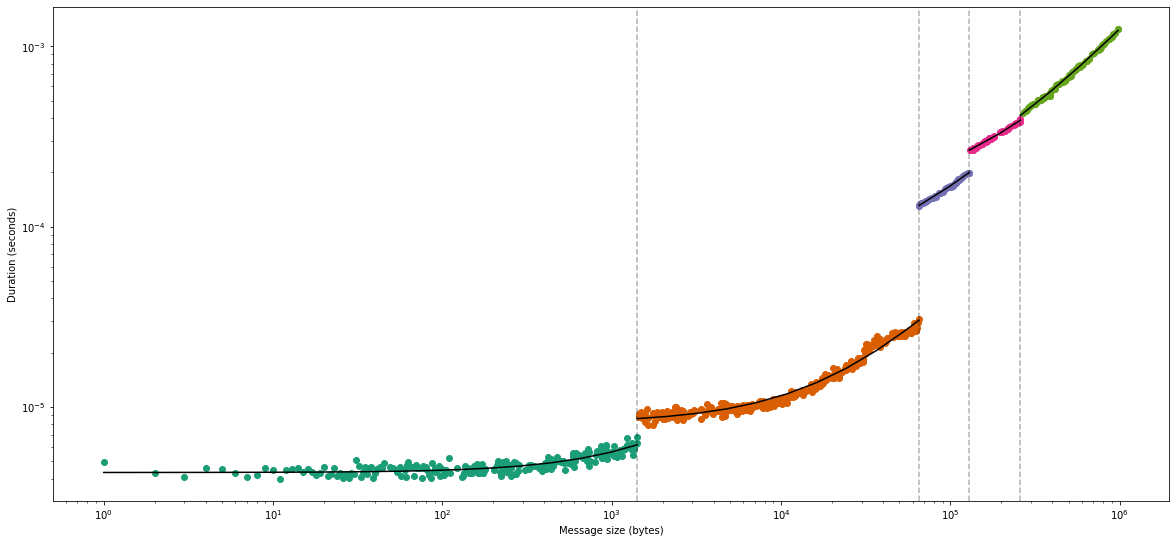

In [12]:
draw_plot(reg_recv)

In [13]:
breakpoints_recv = set(reg_recv.breakpoints)
breakpoints_recv

{1416, 65465, 129554, 259512}

### Pingpong

In [14]:
tmp = aggregate_dataframe(df_pingpong)
reg_pingpong = pytree.compute_regression(x=tmp.msg_size, y=tmp.duration).auto_simplify()
print(reg_pingpong.breakpoints)
reg_pingpong

[1615, 65465, 97442, 129554]


-inf < x ≤ 1.615e+03
	y ~ 3.880e-08x + 4.880e-05
1.615e+03 < x ≤ 6.546e+04
	y ~ 1.885e-09x + 1.012e-04
6.546e+04 < x ≤ 9.744e+04
	y ~ 3.891e-09x + 7.680e-05
9.744e+04 < x ≤ 1.296e+05
	y ~ 1.528e-09x + 2.923e-04
1.296e+05 < x ≤ inf
	y ~ 2.301e-09x + 3.013e-04

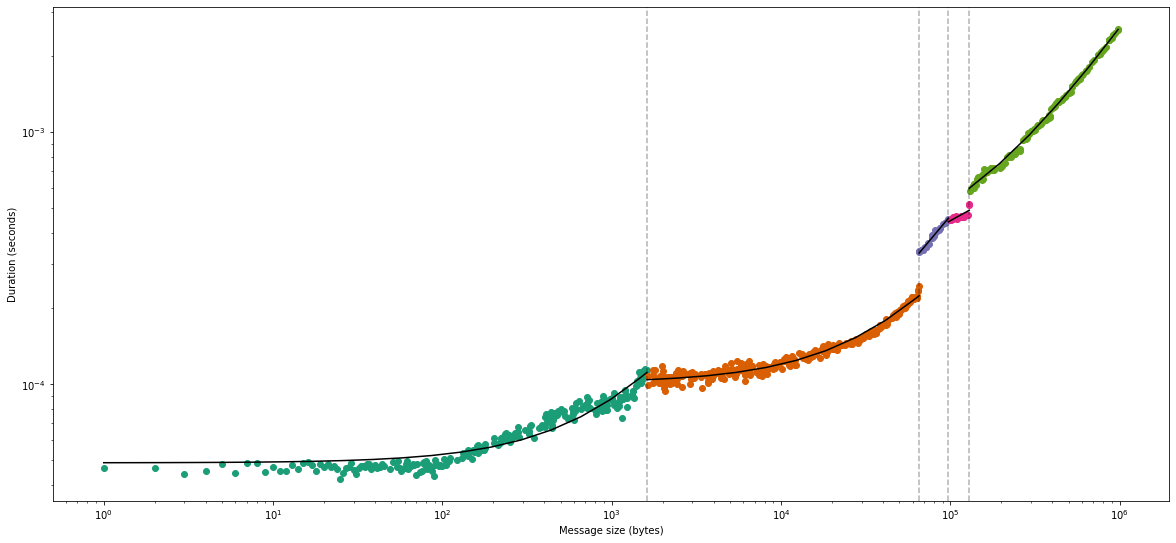

In [15]:
draw_plot(reg_pingpong)

In [16]:
breakpoints_pingpong = set(reg_pingpong.breakpoints)
breakpoints_pingpong

{1615, 65465, 97442, 129554}

In [17]:
import json
history = json.loads(zipfile.ZipFile(archive_name).read('history.json'))
semantic_bp = [cmd for cmd in history if cmd['command'].startswith('python3')]
assert len(semantic_bp) == 1
semantic_bp = semantic_bp[0]
print(semantic_bp['stdout'])

mpirun --allow-run-as-root -np 2 -host paravance-62.rennes.grid5000.fr,paravance-64.rennes.grid5000.fr bp_search2 1
mpirun --allow-run-as-root -np 2 -host paravance-62.rennes.grid5000.fr,paravance-64.rennes.grid5000.fr bp_search1 1
mpirun --allow-run-as-root -np 2 -host paravance-62.rennes.grid5000.fr,paravance-64.rennes.grid5000.fr bp_search1 1000000
mpirun --allow-run-as-root -np 2 -host paravance-62.rennes.grid5000.fr,paravance-64.rennes.grid5000.fr bp_search1 2
mpirun --allow-run-as-root -np 2 -host paravance-62.rennes.grid5000.fr,paravance-64.rennes.grid5000.fr bp_search1 4
mpirun --allow-run-as-root -np 2 -host paravance-62.rennes.grid5000.fr,paravance-64.rennes.grid5000.fr bp_search1 8
mpirun --allow-run-as-root -np 2 -host paravance-62.rennes.grid5000.fr,paravance-64.rennes.grid5000.fr bp_search1 16
mpirun --allow-run-as-root -np 2 -host paravance-62.rennes.grid5000.fr,paravance-64.rennes.grid5000.fr bp_search1 32
mpirun --allow-run-as-root -np 2 -host paravance-62.rennes.grid5

## Better regressions

Let's use the same breakpoints everywhere.

In [18]:
breakpoints = list(sorted(set.union(breakpoints_send, breakpoints_isend, breakpoints_recv, breakpoints_pingpong)))
breakpoints

[1392, 1416, 1615, 65465, 97442, 129554, 250309, 259512, 385716]

In [19]:
breakpoints = set(breakpoints)
breakpoints -= {1392, 1615, 65465, 97442, 259512}
breakpoints.add(65480)
breakpoints = list(sorted(breakpoints))
assert threshold in breakpoints
breakpoints

[1416, 65480, 129554, 250309, 385716]

In [20]:
def my_join(*values, inner_sep=':', outer_sep=';'):
    result = []
    for items in zip(*values):
        result.append(inner_sep.join([str(it) for it in items]))
    return outer_sep.join(result)

def regression_to_str(reg_df, drop_threshold=None, keys=['intercept', 'coefficient']):
    if drop_threshold is not None:
        reg_df.loc[reg_df.min_x >= drop_threshold, 'intercept'] = 0
        reg_df.loc[reg_df.min_x >= drop_threshold, 'coefficient'] = 0
    reg_df.loc[reg_df.min_x < 0, 'min_x'] = 0
    reg_df.min_x = reg_df.min_x.astype(int)
    reg_df.loc[reg_df.coefficient < 0, 'coefficient'] = 0
    reg_df.loc[reg_df.intercept < 0, 'intercept'] = 0
    reg_df.sort_values(by='min_x')
    values = [reg_df.min_x]
    for key in keys:
        values.append(reg_df[key])
    return my_join(*values)

### MPI_Send

-inf < x ≤ 1.416e+03
	y ~ 1.433e-10x + 2.711e-06
1.416e+03 < x ≤ 6.548e+04
	y ~ 6.439e-11x + 3.109e-06
6.548e+04 < x ≤ 1.296e+05
	y ~ 3.802e-10x + 5.858e-05
1.296e+05 < x ≤ 2.503e+05
	y ~ 1.259e-10x + 9.428e-05
2.503e+05 < x ≤ 3.857e+05
	y ~ 3.192e-10x + 1.891e-04
3.857e+05 < x ≤ inf
	y ~ 1.074e-09x + 7.765e-06


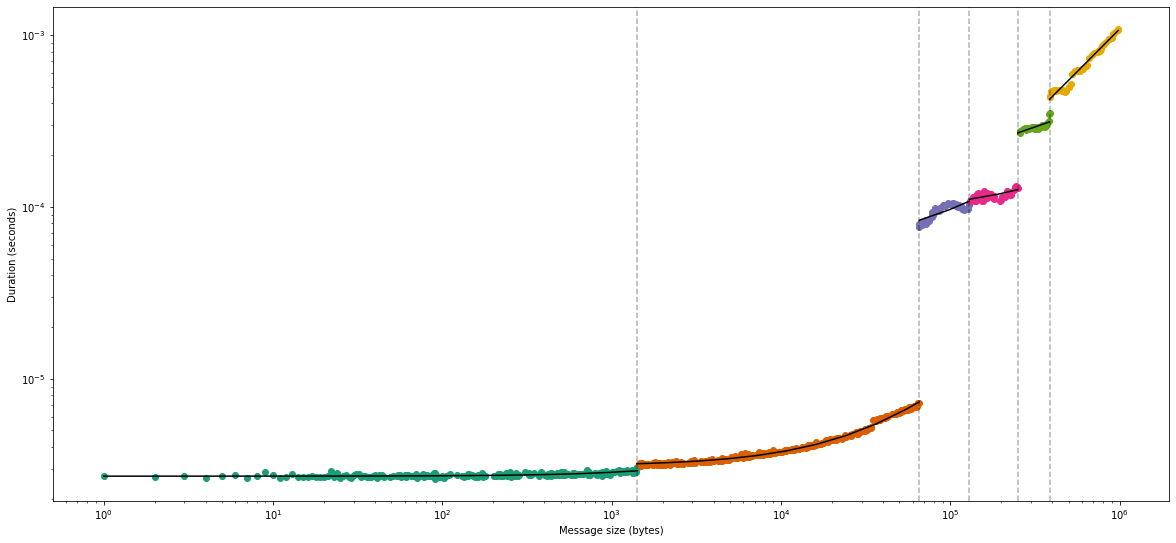

In [21]:
tmp = aggregate_dataframe(df_send)
reg_send = pytree.compute_regression(x=tmp.msg_size, y=tmp.duration, breakpoints=breakpoints)
print(reg_send)
draw_plot(reg_send)

In [22]:
reg_send_str = regression_to_str(reg_send.to_pandas(), drop_threshold=threshold)
reg_send_str

'0:2.7108892118448524e-06:1.432753405704226e-10;1416:3.109310304245123e-06:6.438881093085975e-11;65480:0.0:0.0;129554:0.0:0.0;250309:0.0:0.0;385716:0.0:0.0'

### MPI_Isend

-inf < x ≤ 1.416e+03
	y ~ 1.295e-10x + 3.006e-06
1.416e+03 < x ≤ 6.548e+04
	y ~ 6.161e-11x + 3.313e-06
6.548e+04 < x ≤ 1.296e+05
	y ~ 3.357e-12x + 3.018e-06
1.296e+05 < x ≤ 2.503e+05
	y ~ 1.731e-13x + 3.225e-06
2.503e+05 < x ≤ 3.857e+05
	y ~ 2.702e-13x + 3.230e-06
3.857e+05 < x ≤ inf
	y ~ 2.478e-13x + 3.211e-06


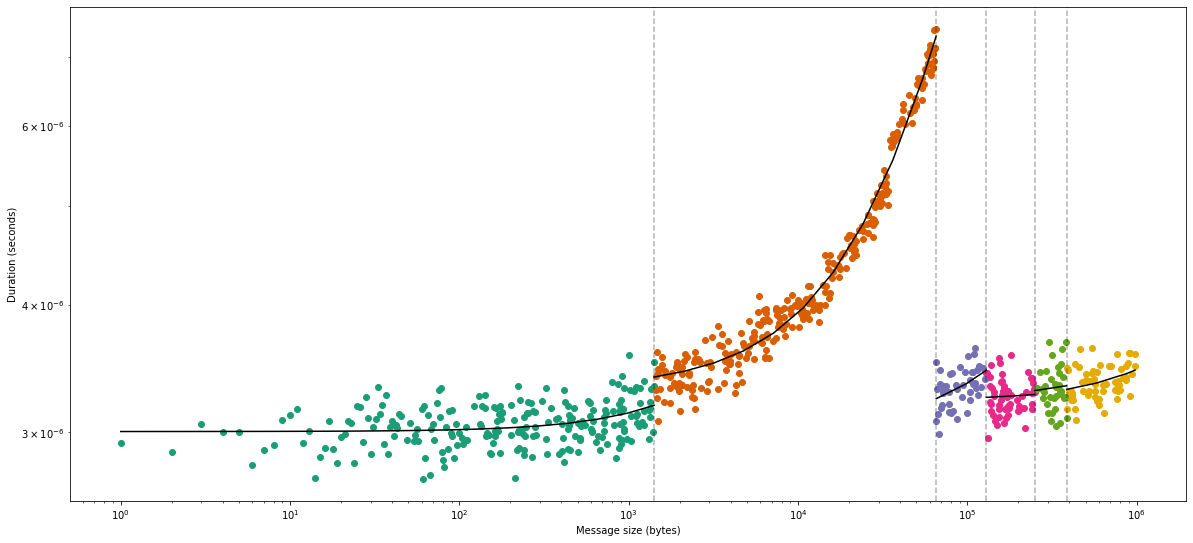

In [23]:
tmp = aggregate_dataframe(df_isend)
reg_isend = pytree.compute_regression(x=tmp.msg_size, y=tmp.duration, breakpoints=breakpoints)
print(reg_isend)
draw_plot(reg_isend)

In [24]:
reg_isend_str = regression_to_str(reg_isend.to_pandas())
reg_isend_str

'0:3.0060582233072994e-06:1.2949499332161986e-10;1416:3.3131664831673444e-06:6.16072310283857e-11;65480:3.017881498809607e-06:3.356979717441256e-12;129554:3.2251735956609496e-06:1.7313977471279236e-13;250309:3.229893975987937e-06:2.7016520591770337e-13;385716:3.2105154072169426e-06:2.478497528158371e-13'

### MPI_Recv

-inf < x ≤ 1.416e+03
	y ~ 1.295e-09x + 4.324e-06
1.416e+03 < x ≤ 6.548e+04
	y ~ 3.387e-10x + 8.125e-06
6.548e+04 < x ≤ 1.296e+05
	y ~ 1.073e-09x + 6.079e-05
1.296e+05 < x ≤ 2.503e+05
	y ~ 9.585e-10x + 1.409e-04
2.503e+05 < x ≤ 3.857e+05
	y ~ 1.072e-09x + 1.387e-04
3.857e+05 < x ≤ inf
	y ~ 1.138e-09x + 1.123e-04


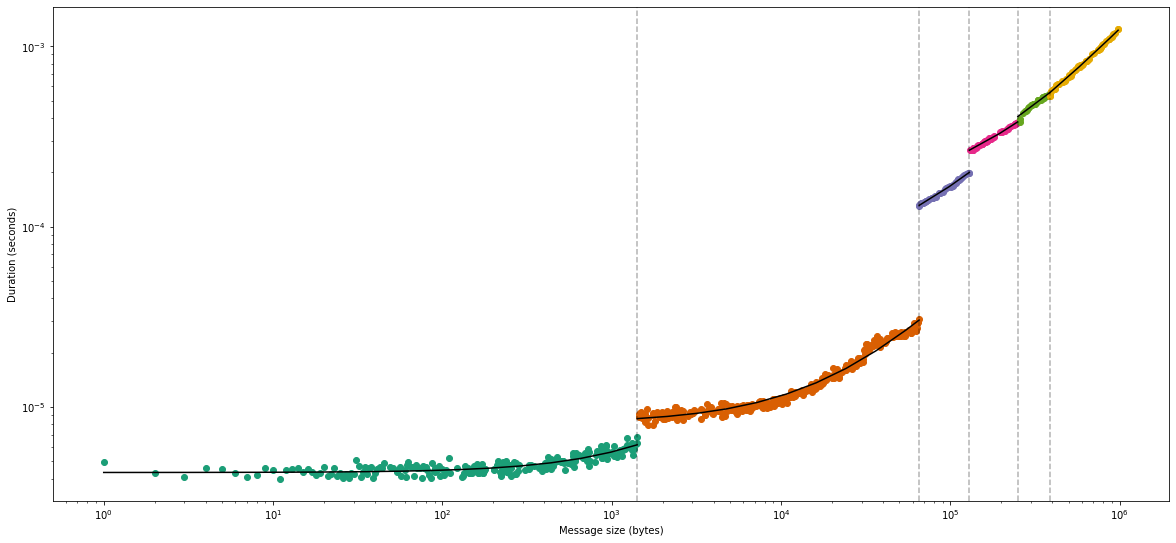

In [25]:
tmp = aggregate_dataframe(df_recv)
reg_recv = pytree.compute_regression(x=tmp.msg_size, y=tmp.duration, breakpoints=breakpoints)
print(reg_recv)
draw_plot(reg_recv)

In [26]:
reg_recv_str = regression_to_str(reg_recv.to_pandas(), drop_threshold=threshold)
reg_recv_str

'0:4.3239492327926595e-06:1.2954254806034372e-09;1416:8.125102238821709e-06:3.387442613661333e-10;65480:0.0:0.0;129554:0.0:0.0;250309:0.0:0.0;385716:0.0:0.0'

### Pingpong

-inf < x ≤ 1.416e+03
	y ~ 3.855e-08x + 4.887e-05
1.416e+03 < x ≤ 6.548e+04
	y ~ 1.877e-09x + 1.015e-04
6.548e+04 < x ≤ 1.296e+05
	y ~ 2.540e-09x + 1.799e-04
1.296e+05 < x ≤ 2.503e+05
	y ~ 1.974e-09x + 3.594e-04
2.503e+05 < x ≤ 3.857e+05
	y ~ 2.163e-09x + 3.409e-04
3.857e+05 < x ≤ inf
	y ~ 2.287e-09x + 3.133e-04


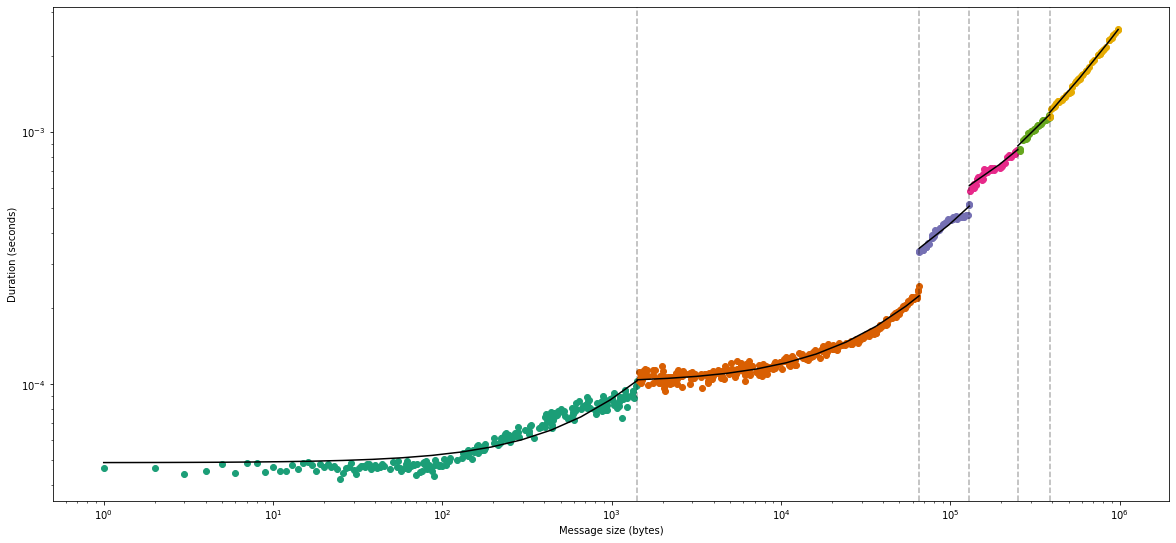

In [27]:
tmp = aggregate_dataframe(df_pingpong)
reg_pingpong = pytree.compute_regression(x=tmp.msg_size, y=tmp.duration, breakpoints=breakpoints)
print(reg_pingpong)
draw_plot(reg_pingpong)

In [28]:
df_reg_recv = reg_recv.to_pandas()
df_reg_send = reg_send.to_pandas()
df_reg_pingpong = reg_pingpong.to_pandas()
df_reg_transfer = df_reg_pingpong[['coefficient', 'intercept', 'max_x', 'min_x']].copy()
df_reg_transfer.loc[df_reg_transfer['max_x'] <= threshold, 'coefficient'] -= df_reg_recv[df_reg_recv['max_x'] <= threshold]['coefficient']
df_reg_transfer.loc[df_reg_transfer['max_x'] <= threshold, 'intercept'] -= df_reg_recv[df_reg_recv['max_x'] <= threshold]['intercept']
df_reg_transfer.loc[df_reg_transfer['max_x'] <= threshold, 'coefficient'] -= df_reg_send[df_reg_send['max_x'] <= threshold]['coefficient']
df_reg_transfer.loc[df_reg_transfer['max_x'] <= threshold, 'intercept'] -= df_reg_send[df_reg_send['max_x'] <= threshold]['intercept']
df_reg_transfer['coefficient'] /= 2
df_reg_transfer['intercept'] /= 2
df_reg_transfer

,coefficient,intercept,max_x,min_x
0,1.855385e-08,0.000021,1416.0,-inf
1,7.367373e-10,0.000045,65480.0,1416.0
2,1.270107e-09,0.000090,129554.0,65480.0
3,9.867779e-10,0.000180,250309.0,129554.0
4,1.081693e-09,0.000170,385716.0,250309.0
5,1.143484e-09,0.000157,inf,385716.0


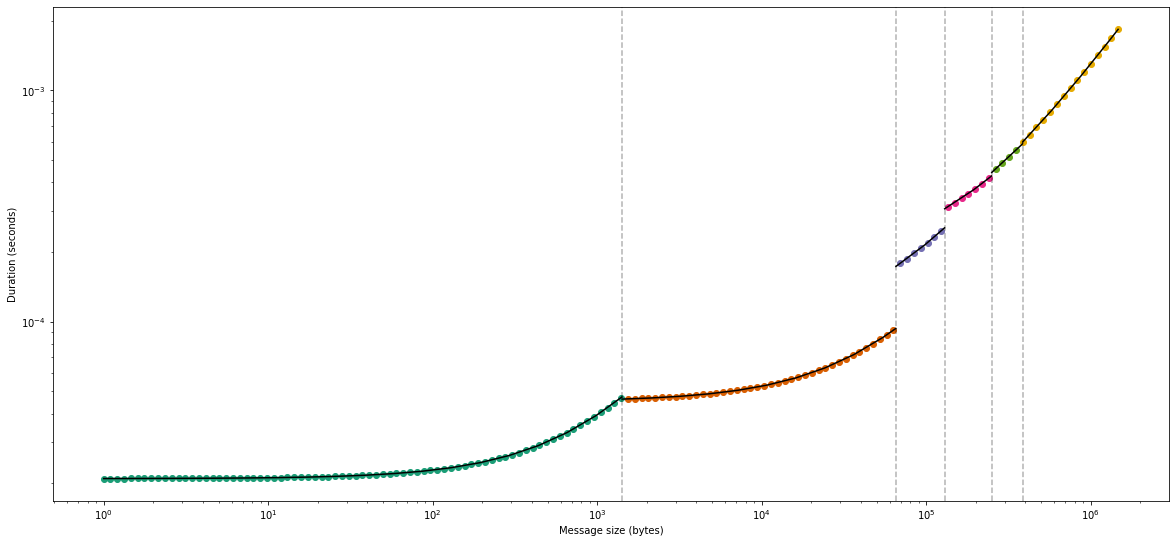

In [29]:
def predict(reg, x):
    for row in reg.iterrows():
        _, row = row
        if row.min_x <= x < row.max_x:
            return row.coefficient * x + row.intercept

tmp = pandas.DataFrame({'x': [1.1**i for i in range(150)]})
tmp['y'] = tmp.apply(lambda row: predict(df_reg_transfer, row.x), axis=1)
draw_plot(pytree.compute_regression(x=tmp.x, y=tmp.y, breakpoints=breakpoints))

In [30]:
df_reg_transfer['bandwidth_factor'] = 1/(df_reg_transfer.coefficient*expected_bandwidth)
df_reg_transfer['latency_factor']   = df_reg_transfer.intercept/expected_latency / 2

pandas.set_option('display.float_format', lambda x: '%.2e' % x)
df_reg_transfer

,coefficient,intercept,max_x,min_x,bandwidth_factor,latency_factor
0,1.86e-08,2.09e-05,1.42e+03,-inf,4.31e-02,1.05e+00
1,7.37e-10,4.51e-05,6.55e+04,1.42e+03,1.09e+00,2.26e+00
2,1.27e-09,8.99e-05,1.30e+05,6.55e+04,6.30e-01,4.50e+00
3,9.87e-10,1.80e-04,2.50e+05,1.30e+05,8.11e-01,8.99e+00
4,1.08e-09,1.70e-04,3.86e+05,2.50e+05,7.40e-01,8.52e+00
5,1.14e-09,1.57e-04,inf,3.86e+05,7.00e-01,7.83e+00


#### <span style="color:red;text-decoration: underline">/!\\   WARNING   /!\\</span>

The above code is intended for a topology similar to:  `[node]---[switch]---[node]`

For this reason, we divided the latency factor by 2.

If the two nodes were directly connected, without switch, we would *not* divide the latency factor. Similarly, we would divide by a larger integer if there were more hops.

In [31]:
bandwidth_str = regression_to_str(df_reg_transfer, drop_threshold=threshold, keys=['bandwidth_factor'])
latency_str = regression_to_str(df_reg_transfer, drop_threshold=threshold, keys=['latency_factor'])

print(bandwidth_str)
print(latency_str)

min_lat_factor = df_reg_transfer[df_reg_transfer.min_x == float('-inf')].latency_factor.min()
max_bw_factor = df_reg_transfer[df_reg_transfer.max_x == float('inf')].bandwidth_factor.max()

0:0.043117740751190896;1416:1.0858686867111624;65480:0.629868292975373;129554:0.8107193845607635;250309:0.739581541304429;385716:0.6996165497807703
0:1.045872482413566;1416:2.257283145959299;65480:4.4968348633736905;129554:8.986088815194826;250309:8.523555537742846;385716:7.831615753631102


### Wtime

5.395218181818182e-07


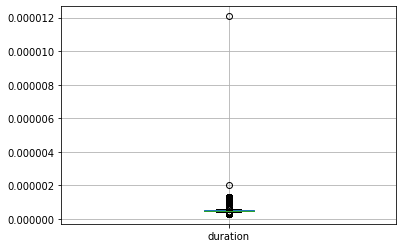

In [32]:
wtime_mean = df_wtime.duration.mean()
print(wtime_mean)
df_wtime.boxplot('duration')

### Test

8.477165098573299e-07


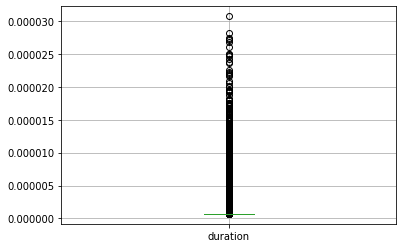

In [33]:
test_mean = df_test.duration.mean()
print(test_mean)
df_test.boxplot('duration')

### Iprobe

9.007824203737025e-07


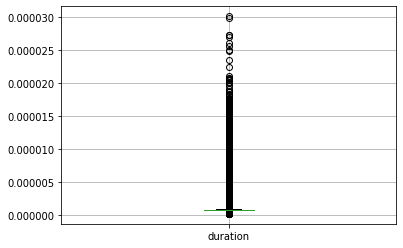

In [34]:
iprobe_mean = df_iprobe.duration.mean()
print(iprobe_mean)
df_iprobe.boxplot('duration')

## Loopback

In [35]:
loopback_archive_name = 'rennes_2019-08-06_1176781.zip'
assert loopback_archive_name != archive_name

loopback_result = extract_zip(loopback_archive_name)

# Special processing for the Pingpong dataset
df_pingpong_loopback = loopback_result['exp/exp_PingPong.csv']
pingpong_send_loopback = df_pingpong_loopback[df_pingpong_loopback.op=='MPI_Send'].reset_index(drop=True)
pingpong_recv_loopback = df_pingpong_loopback[df_pingpong_loopback.op=='MPI_Recv'].reset_index(drop=True)
df_pingpong_loopback = pandas.DataFrame(dict(op = 'PingPong',
                   msg_size = pingpong_send_loopback.msg_size,
                   start    = pingpong_send_loopback.start,
                   duration = pingpong_recv_loopback.duration + pingpong_send_loopback.duration
              ))

df_recv_loopback = loopback_result['exp/exp_Recv.csv']

df_pingpong_loopback.head()

,op,msg_size,start,duration
0,PingPong,168,7.29e-03,1.16e-06
1,PingPong,168,7.30e-03,8.32e-07
2,PingPong,168,7.30e-03,8.29e-07
3,PingPong,168,7.30e-03,6.58e-07
4,PingPong,168,7.30e-03,7.90e-07


### Loopback latency

4.34442e-07


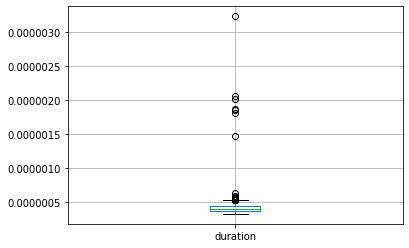

In [36]:
min_recv = df_recv_loopback[df_recv_loopback.msg_size == df_recv_loopback.msg_size.min()]
mean_min_recv = min_recv.duration.mean()
print(mean_min_recv)
min_recv.boxplot('duration')

5.861120000000001e-07


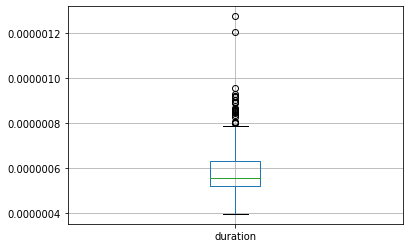

In [37]:
min_pingpong = df_pingpong_loopback[df_pingpong_loopback.msg_size == df_pingpong_loopback.msg_size.min()]
mean_min_pingpong = min_pingpong.duration.mean()
print(mean_min_pingpong)
min_pingpong.boxplot('duration')

In [38]:
loopback_latency = mean_min_pingpong/2 - mean_min_recv
theoretical_loopback_latency = max(0, loopback_latency / min_lat_factor)
theoretical_loopback_latency

0

### Loopback bandwidth

0.00017770170199999999


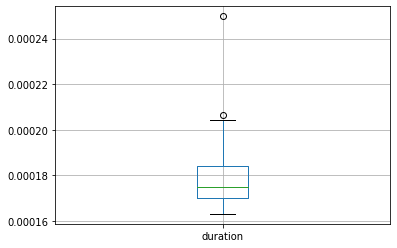

In [39]:
max_size = df_pingpong_loopback.msg_size.max()
max_pingpong = df_pingpong_loopback[df_pingpong_loopback.msg_size == max_size]
mean_max_pingpong = max_pingpong.duration.mean()
print(mean_max_pingpong)
max_pingpong.boxplot('duration')

In [40]:
loopback_bandwidth = 2/(mean_max_pingpong/max_size)
theoretical_loopback_bandwidth = loopback_bandwidth / max_bw_factor
theoretical_loopback_bandwidth

15769947520.45981

## XML generation

In [41]:
config = f'''
<?xml version="1.0"?>
<!DOCTYPE platform SYSTEM "http://simgrid.gforge.inria.fr/simgrid/simgrid.dtd">

<platform version="4.1">
    <config id="General">
        <prop id="smpi/os" value="{reg_send_str}"/>
        <prop id="smpi/or" value="{reg_recv_str}"/>
        <prop id="smpi/ois" value="{reg_isend_str}"/>
        <prop id="smpi/bw-factor" value="{bandwidth_str}"/>
        <prop id="smpi/lat-factor" value="{latency_str}"/>
        <prop id="smpi/async-small-thresh" value="{threshold}"/>
        <prop id="smpi/send-is-detached-thresh" value="{threshold}"/>
        <prop id="smpi/iprobe" value="{iprobe_mean}"/>
        <prop id="smpi/test" value="{test_mean}"/>
        <prop id="smpi/host-speed" value="1"/>
    </config>

    <AS id="AS0" routing="Full">
        <cluster id="cluster" prefix="paravance-" suffix=".rennes.grid5000.fr" radical="1-72" speed="1" core="16" bw="{expected_bandwidth*1e-9}GBps" lat="{'%.2f' % (expected_latency*1e6)}us" loopback_bw="{theoretical_loopback_bandwidth*1e-9}GBps" loopback_lat="{theoretical_loopback_latency*1e6}us"/>
    </AS>
</platform>
'''

# Note: I removed the wtime property because I do not need it, feel free to add it back: <prop id="smpi/wtime" value="{wtime_mean}"/>

from IPython.display import display, Markdown
display(Markdown('```xml\n%s\n```' % config))

```xml

<?xml version="1.0"?>
<!DOCTYPE platform SYSTEM "http://simgrid.gforge.inria.fr/simgrid/simgrid.dtd">

<platform version="4.1">
    <config id="General">
        <prop id="smpi/os" value="0:2.7108892118448524e-06:1.432753405704226e-10;1416:3.109310304245123e-06:6.438881093085975e-11;65480:0.0:0.0;129554:0.0:0.0;250309:0.0:0.0;385716:0.0:0.0"/>
        <prop id="smpi/or" value="0:4.3239492327926595e-06:1.2954254806034372e-09;1416:8.125102238821709e-06:3.387442613661333e-10;65480:0.0:0.0;129554:0.0:0.0;250309:0.0:0.0;385716:0.0:0.0"/>
        <prop id="smpi/ois" value="0:3.0060582233072994e-06:1.2949499332161986e-10;1416:3.3131664831673444e-06:6.16072310283857e-11;65480:3.017881498809607e-06:3.356979717441256e-12;129554:3.2251735956609496e-06:1.7313977471279236e-13;250309:3.229893975987937e-06:2.7016520591770337e-13;385716:3.2105154072169426e-06:2.478497528158371e-13"/>
        <prop id="smpi/bw-factor" value="0:0.043117740751190896;1416:1.0858686867111624;65480:0.629868292975373;129554:0.8107193845607635;250309:0.739581541304429;385716:0.6996165497807703"/>
        <prop id="smpi/lat-factor" value="0:1.045872482413566;1416:2.257283145959299;65480:4.4968348633736905;129554:8.986088815194826;250309:8.523555537742846;385716:7.831615753631102"/>
        <prop id="smpi/async-small-thresh" value="65480"/>
        <prop id="smpi/send-is-detached-thresh" value="65480"/>
        <prop id="smpi/iprobe" value="9.007824203737025e-07"/>
        <prop id="smpi/test" value="8.477165098573299e-07"/>
        <prop id="smpi/host-speed" value="1"/>
    </config>

    <AS id="AS0" routing="Full">
        <cluster id="cluster" prefix="paravance-" suffix=".rennes.grid5000.fr" radical="1-72" speed="1" core="16" bw="1.25GBps" lat="10.00us" loopback_bw="15.76994752045981GBps" loopback_lat="0.0us"/>
    </AS>
</platform>

```

In [42]:
reg_recv.breakpoints

[1416, 65480, 129554, 250309, 385716]

## Pretty plots

In [43]:
import plotnine
plotnine.options.figure_size = (12, 8)
from plotnine import *

In [44]:
def pretty_plot(df, reg, n=10000):
    df = df.sample(n=n).copy()
    df['pred'] = df.apply(lambda row: reg.predict(row['msg_size']), axis=1)
    df['group'] = 0
    for i, bp in enumerate(reg.breakpoints):
        df.loc[df['msg_size'] > bp, 'group'] = i+1
    plot = ggplot(df) + geom_point(aes(x='msg_size', y='duration', color='factor(group)'), alpha=0.5, show_legend=False)
    breakpoints = list(reg.breakpoints)
    for bp in breakpoints:
        plot = plot + geom_vline(xintercept=bp, linetype='dashed', color='gray')
    breakpoints = [float('-inf')] + breakpoints + [float('inf')]
    for bp1, bp2 in zip(breakpoints[:-1], breakpoints[1:]):
        plot = plot + geom_line(df[(df.msg_size > bp1) & (df.msg_size < bp2)], aes(x='msg_size', y='pred'), size=1)
    plot = plot + theme_bw() + scale_x_log10() + scale_y_log10() + xlab('Message size (bytes)') + ylab('Duration (seconds)')
    op = df['op'].unique()[0]
    plot = plot + ggtitle('Durations of %s' % op)
    return plot

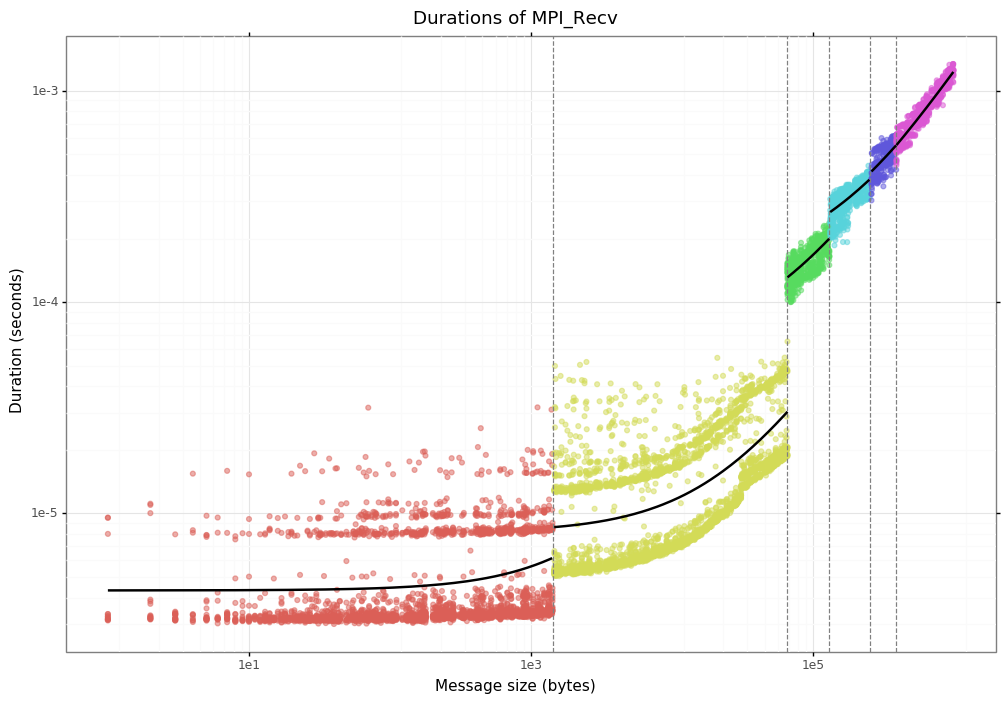

<ggplot: (-9223363307792669822)>

In [45]:
plot = pretty_plot(df_recv, reg_recv)
plot.save('/tmp/recv.pdf')
plot

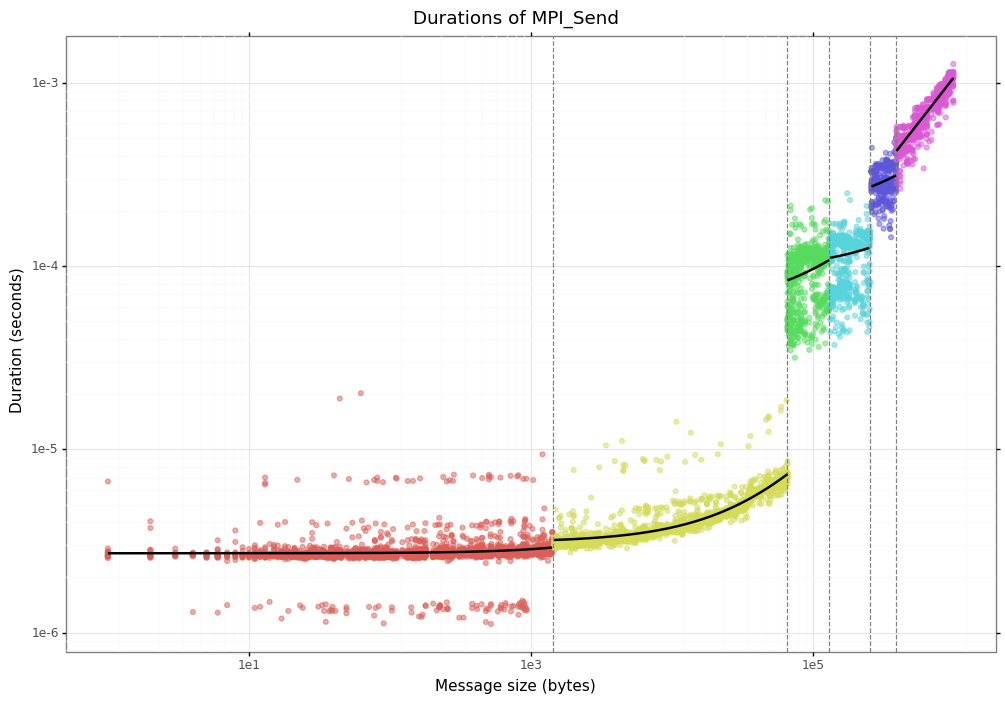

<ggplot: (-9223363307759959166)>

In [46]:
plot = pretty_plot(df_send, reg_send)
plot.save('/tmp/send.pdf')
plot